# Introdução
Este projeto tem como objetivo descobrir se há alguma relação entre o preço de um produto e sua avaliação. Além da avaliação serão usadas algumas features para tentar

# 1. Lendo bibliotecas

In [1]:
import numpy as np
import pandas as pd
import os
import math
# Regressão Linear
from sklearn import datasets, linear_model
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.tree import DecisionTreeRegressor


import seaborn as sns
%matplotlib inline

# Plots
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display

# 2. Ler o DataSet

In [2]:
filename = 'dataset.xlsx'
if not filename in os.listdir():
    print(f'Não encontrei o arquivo {filename}')

In [3]:
dados = pd.read_excel(filename)
print(f"Temos as colunas {dados.columns}")

Temos as colunas Index(['price (£)', 'number_of_reviews', 'rating', 'category'], dtype='object')


# 3. Tratamento da coluna 'Category'
A coluna category na prática é uma hierarquia de categorias que podem se misturar. Ex. A subcategoria celulares pode estar tanto dentro de comunicação quanto de tecnologia. Nesta etapa vamos separar a categoria em categoria, subcategoria e subsubcategoria.

In [4]:
# dados['parentcategory', 'subcategory', 'subsubcategory'] = dados['category'].str.split(' > ')
dados['parentcategory'] = dados['category'].map(lambda category: category.split(' > ')[0])
dados['subcategory'] = dados['category'].map(lambda category: category.split(' > ')[1])
dados['subsubcategory'] = dados['category'].map(lambda category: category.split(' > ')[2] if 2 < len(category.split(' > ')) else "Outros")

dados.head()

,price (£),number_of_reviews,rating,category,parentcategory,subcategory,subsubcategory
0,3.42,15,4.9,Hobbies > Model Trains & Railway Sets > Rail V...,Hobbies,Model Trains & Railway Sets,Rail Vehicles
1,16.99,2,4.5,Hobbies > Model Trains & Railway Sets > Rail V...,Hobbies,Model Trains & Railway Sets,Rail Vehicles
2,9.99,17,3.9,Hobbies > Model Trains & Railway Sets > Rail V...,Hobbies,Model Trains & Railway Sets,Rail Vehicles
3,39.99,1,5.0,Hobbies > Model Trains & Railway Sets > Rail V...,Hobbies,Model Trains & Railway Sets,Rail Vehicles
4,32.19,3,4.7,Hobbies > Model Trains & Railway Sets > Rail V...,Hobbies,Model Trains & Railway Sets,Rail Vehicles


**Apos separar as categorias fizemos um Valeu counts de cada uma para ver quantos valores à em cada categoria**

**Valeu counts ParentCategory**

In [5]:
dados['parentcategory'].value_counts()

Hobbies                             1198
Die-Cast & Toy Vehicles             1072
Figures & Playsets                   890
Games                                795
Characters & Brands                  747
Arts & Crafts                        741
Party Supplies                       672
Fancy Dress                          526
Dolls & Accessories                  337
Sports Toys & Outdoor                335
Puppets & Puppet Theatres            246
Jigsaws & Puzzles                    230
Baby & Toddler Toys                   77
Pretend Play                          39
Musical Toy Instruments               15
Novelty & Special Use                 10
Pens, Pencils & Writing Supplies       7
Office Supplies                        6
Home Accessories                       5
Bags                                   4
Cooking & Dining                       4
Worlds Apart                           3
Electronic Toys                        3
Educational Toys                       3
Gardening       

**Valeu counts SubCategory**

In [6]:
dados['subcategory'].value_counts()

Toy Vehicles & Accessories     966
Accessories                    530
Children's Craft Kits          390
Science Fiction & Fantasy      359
Model Trains & Railway Sets    328
                              ... 
Marvin's Magic                   1
Winnie-the-Pooh                  1
Drawing & Painting Supplies      1
Pencils                          1
Drinking Games                   1
Name: subcategory, Length: 138, dtype: int64

**Valeu counts SubsubCategory**

In [7]:
dados['subsubcategory'].value_counts()


Outros                         3275
Scaled Models                   866
Toys                            504
Bead Art & Jewellery-Making     340
Balloons                        284
                               ... 
Thread                            1
Poker Chip Cases & Trays          1
Books                             1
Paints                            1
Fashion Dolls                     1
Name: subsubcategory, Length: 104, dtype: int64

**Problema**: Temos muitas categorias com poucos dados. Para isso vamos trocá-las por "outros"

In [8]:
dados['new_parentcategory'] = dados['parentcategory'].map(lambda category: category if dados['parentcategory'].value_counts()[category] >= 300 else 'Outros')
dados['new_subcategory'] = dados['subcategory'].map(lambda category: category if dados['subcategory'].value_counts()[category] >= 300 else 'Outros')
dados['new_subsubcategory'] = dados['subsubcategory'].map(lambda category:  category if dados['subsubcategory'].value_counts()[category] >= 300 else 'Outros')

**Valeu counts ParentCategory**

In [9]:
dados['new_parentcategory'].value_counts()

Hobbies                    1198
Die-Cast & Toy Vehicles    1072
Figures & Playsets          890
Games                       795
Characters & Brands         747
Arts & Crafts               741
Outros                      673
Party Supplies              672
Fancy Dress                 526
Dolls & Accessories         337
Sports Toys & Outdoor       335
Name: new_parentcategory, dtype: int64

**Valeu counts SubCategory**

In [10]:
dados['new_subcategory'].value_counts()

Outros                          4779
Toy Vehicles & Accessories       966
Accessories                      530
Children's Craft Kits            390
Science Fiction & Fantasy        359
Model Trains & Railway Sets      328
Banners, Stickers & Confetti     328
Decorations                      306
Name: new_subcategory, dtype: int64

**Valeu counts SubsubCategory**

In [11]:
dados['new_subsubcategory'].value_counts()

Outros                         6276
Scaled Models                   866
Toys                            504
Bead Art & Jewellery-Making     340
Name: new_subsubcategory, dtype: int64

# 4. Análise Exploratória
O primeiro passo após ter o DataSet carregado é olhar os dados e tentar descobrir possíveis correlações. Para isso vamos plotar alguns gráficos:

**Primeiramente buscamos a utilizar os dados da funcao Describe para assim plotar os graficos!**

In [12]:
print(dados.describe(include = 'all'))

          price (£)  number_of_reviews       rating  \
count   7986.000000        7986.000000  7986.000000   
unique          NaN                NaN          NaN   
top             NaN                NaN          NaN   
freq            NaN                NaN          NaN   
mean      19.848063           9.371776     4.709154   
std       39.049344          36.484311     0.372529   
min        0.010000           1.000000     2.300000   
25%        4.630000           1.000000     4.500000   
50%       10.000000           2.000000     5.000000   
75%       19.990000           6.000000     5.000000   
max      995.110000        1399.000000     5.000000   

                                                 category parentcategory  \
count                                                7986           7986   
unique                                                235             40   
top     Die-Cast & Toy Vehicles > Toy Vehicles & Acces...        Hobbies   
freq                               

TODOS GRAFICOS POSSIVEIS


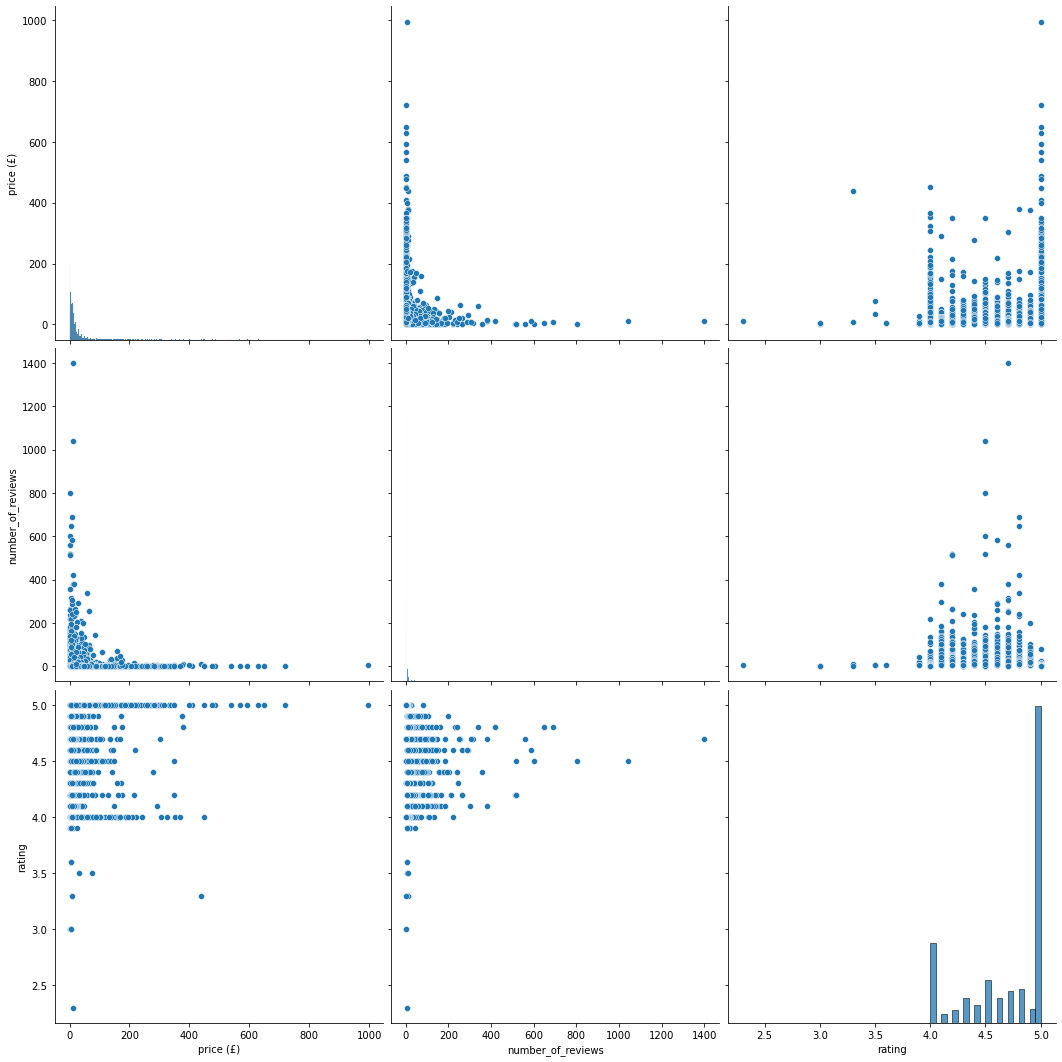

In [13]:
# Todos os gráficos possíveis
print("TODOS GRAFICOS POSSIVEIS")
sns.pairplot(dados,height = 5)


**Gráficos:** Esses gráficos representam nossa análise exploratória, abaixo refizemos os gráficos que consideramos os mais importantes

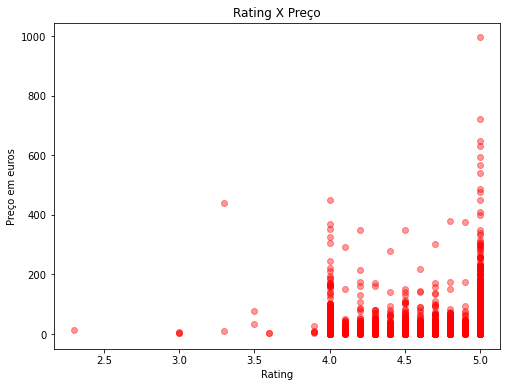

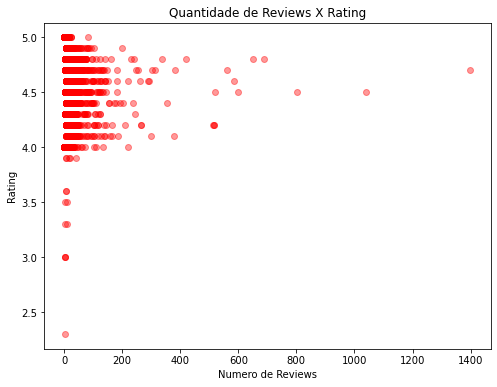

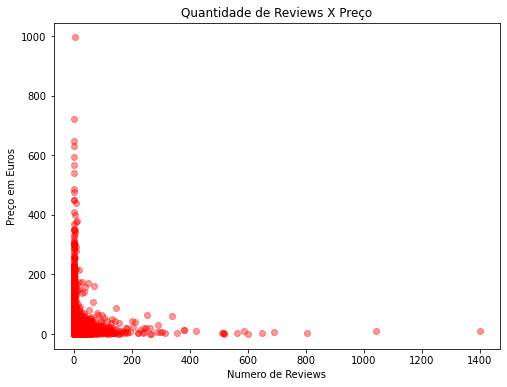

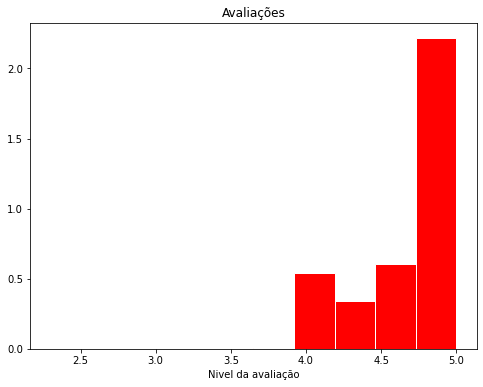

In [14]:

plt.figure(figsize = (8,6))
plt.scatter(dados.rating,dados["price (£)"], c='red', alpha=0.4)
plt.title('Rating X Preço')
plt.xlabel('Rating')
plt.ylabel('Preço em euros')
plt.show()

plt.figure(figsize = (8,6))
plt.scatter(dados.number_of_reviews, dados.rating, c='red', alpha=0.4)
plt.title('Quantidade de Reviews X Rating')
plt.xlabel('Numero de Reviews')
plt.ylabel('Rating')

plt.show()

plt.figure(figsize = (8,6))
plt.scatter(dados.number_of_reviews, dados["price (£)"], c='red', alpha=0.4)
plt.title('Quantidade de Reviews X Preço')
plt.xlabel('Numero de Reviews')
plt.ylabel('Preço em Euros')

plt.figure(figsize = (8,6))
plt.hist(dados.rating, edgecolor = 'white', density = True, color = "red")
plt.title('Avaliações')
plt.xlabel('Nivel da avaliação')

plt.show()




## Observando os gráficos
Para a análise dos produtos, nós vamos usar três principais características: preço, avaliação e número de avaliações; sendo review o target e as demais variáveis features.

A partir dos gráficos acima formulamos a seguinte hipótese: **Quanto maior a avaliação, maior o preço e quanto maior número de reviews, menor o preço do produto**.
Lógica por trás da decisão:
1. Pessoas vão entrar para reclamar se o produto for ruim, mas não necessariamente vão elogiá-lo se for bom;
2. Produtos com boas avaliações tendem a ter melhor qualidade, o que reflete em seu preço

# Tentativa #1 
Neste passo vamos fazer uma regressão linear multivariada utilizando MMQ, levando em consideração a o preço em função da avaliação e número de reviews. Iremos utilizar a bibilioteca 'statsmodels' para tentar obter a previsao de nossos dados!
Nessa tentativa nós usamos apenas as features ratings e numero de reviews

In [15]:
def regress(Y,X):
    '''
    Y: coluna do DataFrame utilizada como variável resposta (TARGET)
    X: coluna(s) do DataFrame utilizadas como variável(is) explicativas (FEATURES)
    '''
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    
    return results

In [16]:
# Target é o preço
y = dados[['price (£)']]

# Vamos usar o preço e número de reviews como features
x = dados[['number_of_reviews', 'rating']]

# Agora vamos fazer MMQ (OLS) com a função regress
resultados = regress(y, x)
resultados.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price (£)   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     9.974
Date:                Tue, 30 Nov 2021   Prob (F-statistic):           4.72e-05
Time:                        13:32:35   Log-Likelihood:                -40588.
No. Observations:                7986   AIC:                         8.118e+04
Df Residuals:                    7983   BIC:                         8.120e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.6675      5.583      0.120      0.905     -10.277      11.612
number_of_reviews    -0.0285      0.012     -2.365      0.018      -0.052      -0.005
rating                4.1297      1.179      3.503      0.000       1.819       6.441
==============================================================================
Omnibus:                    11485.500   Durbin-Watson:                   1.793
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4758387.250
Skew:                           8.533   Prob(JB):                         0.00
Kurtosis:                     121.359   Cond. No.                         493.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
X_cp = sm.add_constant(x)
resultados.predict(X_cp)


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


0       20.475964
1       19.194199
2       16.289319
3       21.287522
4       19.991670
          ...    
7981    21.230581
7982    17.157818
7983    21.287522
7984    21.287522
7985    18.937964
Length: 7986, dtype: float64

**Apos obtermos os dados iremos plotar os seguintes graficos: 'Previsão do preço X Rating' e 'Preço em Libras X Number of Reviews'**

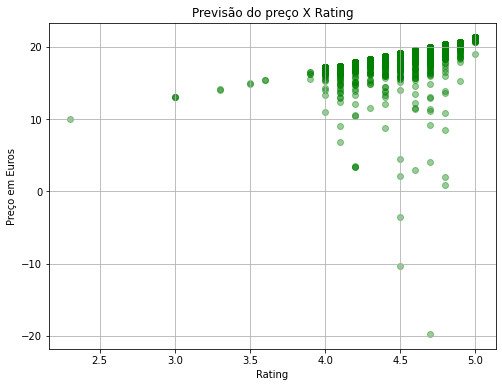

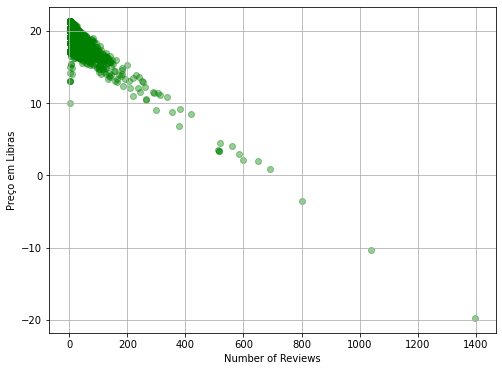

In [18]:
plt.figure(figsize = (8,6))
plt.scatter(dados.rating,resultados.predict(), c='green', alpha=0.4)
plt.title('Previsão do preço X Rating')
plt.grid(True)
plt.xlabel('Rating')
plt.ylabel('Preço em Euros')

plt.figure(figsize = (8,6))
plt.grid(True)
plt.scatter(dados.number_of_reviews,resultados.predict(), c='green', alpha=0.4)
plt.xlabel('Number of Reviews')
plt.ylabel('Preço em Libras')

plt.show()

# TODO: Achar precisão com sklearn.metrics

# Tentativa #2 da regressão linear(DUMMIES) 

In [19]:
dummiesdados = pd.get_dummies(dados, columns=['parentcategory'])
dummiesdados

,price (£),number_of_reviews,rating,category,subcategory,subsubcategory,new_parentcategory,new_subcategory,new_subsubcategory,parentcategory_Arts & Crafts,...,"parentcategory_Pens, Pencils & Writing Supplies",parentcategory_Pretend Play,parentcategory_Puppets & Puppet Theatres,parentcategory_Sex & Sensuality,parentcategory_Sports Toys & Outdoor,"parentcategory_Storage, Cleaning & Ring Sizers",parentcategory_Supporters' Gear,"parentcategory_Sweets, Chocolate & Gum",parentcategory_Women,parentcategory_Worlds Apart
0,3.42,15,4.9,Hobbies > Model Trains & Railway Sets > Rail V...,Model Trains & Railway Sets,Rail Vehicles,Hobbies,Model Trains & Railway Sets,Outros,0,...,0,0,0,0,0,0,0,0,0,0
1,16.99,2,4.5,Hobbies > Model Trains & Railway Sets > Rail V...,Model Trains & Railway Sets,Rail Vehicles,Hobbies,Model Trains & Railway Sets,Outros,0,...,0,0,0,0,0,0,0,0,0,0
2,9.99,17,3.9,Hobbies > Model Trains & Railway Sets > Rail V...,Model Trains & Railway Sets,Rail Vehicles,Hobbies,Model Trains & Railway Sets,Outros,0,...,0,0,0,0,0,0,0,0,0,0
3,39.99,1,5.0,Hobbies > Model Trains & Railway Sets > Rail V...,Model Trains & Railway Sets,Rail Vehicles,Hobbies,Model Trains & Railway Sets,Outros,0,...,0,0,0,0,0,0,0,0,0,0
4,32.19,3,4.7,Hobbies > Model Trains & Railway Sets > Rail V...,Model Trains & Railway Sets,Rail Vehicles,Hobbies,Model Trains & Railway Sets,Outros,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7981,22.95,3,5.0,Hobbies > Collectible Figures & Memorabilia > ...,Collectible Figures & Memorabilia,Collectible Props & Memorabilia,Hobbies,Outros,Outros,0,...,0,0,0,0,0,0,0,0,0,0
7982,39.99,1,4.0,Characters & Brands > Star Wars > Toys,Star Wars,Toys,Characters & Brands,Outros,Toys,0,...,0,0,0,0,0,0,0,0,0,0
7983,43.99,1,5.0,Novelty & Special Use > Novelty > Accessories ...,Novelty,Accessories,Outros,Outros,Outros,0,...,0,0,0,0,0,0,0,0,0,0
7984,49.81,1,5.0,Hobbies > Collectible Figures & Memorabilia > ...,Collectible Figures & Memorabilia,Collectible Props & Memorabilia,Hobbies,Outros,Outros,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:


# Target é o preço
y_d = dummiesdados[['price (£)']].values

# Vamos usar o preço e número de reviews como features
x_d = dummiesdados[['number_of_reviews', 'rating', 'parentcategory_Arts & Crafts',
       'parentcategory_Baby & Toddler Toys', 'parentcategory_Bags',
       'parentcategory_Bedding & Linens', 'parentcategory_Camping & Hiking',
       'parentcategory_Characters & Brands', 'parentcategory_Cooking & Dining',
       'parentcategory_Die-Cast & Toy Vehicles', 'parentcategory_Dogs',
       'parentcategory_Dolls & Accessories', 'parentcategory_Educational Toys',
       'parentcategory_Electronic Toys', 'parentcategory_Fancy Dress',
       'parentcategory_Figures & Playsets', 'parentcategory_Games',
       'parentcategory_Gardening', 'parentcategory_Handbags & Shoulder Bags',
       'parentcategory_Hobbies', 'parentcategory_Home Accessories',
       'parentcategory_Indoor Lighting',
       'parentcategory_Jams, Honey & Spreads',
       'parentcategory_Jigsaws & Puzzles',
       'parentcategory_Laundry, Storage & Organisation',
       'parentcategory_Medication & Remedies', 'parentcategory_Men',
       'parentcategory_Musical Toy Instruments',
       'parentcategory_Novelty & Special Use',
       'parentcategory_Novelty Jewellery', 'parentcategory_Office Supplies',
       'parentcategory_Party Supplies',
       'parentcategory_Pens, Pencils & Writing Supplies',
       'parentcategory_Pretend Play',
       'parentcategory_Puppets & Puppet Theatres',
       'parentcategory_Sex & Sensuality']].values

# Agora vamos fazer MMQ (OLS) com a função regress
resultados_d = regress(y_d, x_d)
resultados.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price (£)   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     9.974
Date:                Tue, 30 Nov 2021   Prob (F-statistic):           4.72e-05
Time:                        13:32:35   Log-Likelihood:                -40588.
No. Observations:                7986   AIC:                         8.118e+04
Df Residuals:                    7983   BIC:                         8.120e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.6675      5.583      0.120      0.905     -10.277      11.612
number_of_reviews    -0.0285      0.012     -2.365      0.018      -0.052      -0.005
rating                4.1297      1.179      3.503      0.000       1.819       6.441
==============================================================================
Omnibus:                    11485.500   Durbin-Watson:                   1.793
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4758387.250
Skew:                           8.533   Prob(JB):                         0.00
Kurtosis:                     121.359   Cond. No.                         493.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

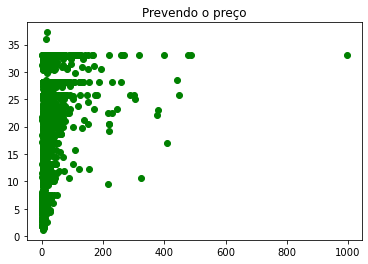

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x_d, y_d, test_size = 0.3)
model = LinearRegression()
model.fit(x_train, y_train)

predictions = model.predict(x_test)
plt.scatter(y_test, predictions, color = 'green')
plt.title('Prevendo o preço')
plt.show()



In [22]:
a = predictions.tolist()
lista = []
i = 0
while i < len(a):
    lista.append(a[i][0])
    i+=1

b = y_test.tolist()
lista2 = []
k = 0
while k < len(b):
    lista2.append(b[k][0])
    k+=1

index = range(0,len(y_test))
df = pd.DataFrame({'Real Values':lista2,'Predicted Values':lista})
df

,Real Values,Predicted Values
0,4.99,24.416040
1,18.24,33.055884
2,54.99,18.679713
3,1.50,4.382334
4,1.80,10.547167
...,...,...
2391,16.99,23.560470
2392,44.73,22.472155
2393,52.97,33.143826
2394,56.11,33.143826


## Tentativa #1 da Decision Tree

In [23]:
# Fitting Decision Tree Regression to the dataset
regressor2 = DecisionTreeRegressor(random_state=0)
regressor2.fit(x_d,y_d)
y_predT = regressor2.predict(x_test)


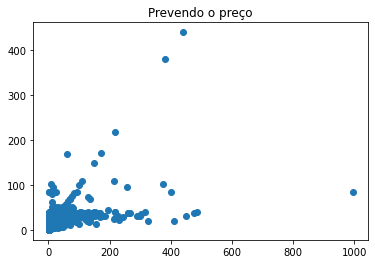

In [24]:
plt.scatter(y_test, y_predT)
plt.title('Prevendo o preço')
plt.show()

In [25]:
df = pd.DataFrame({'Real Values(£)':y_test.reshape(-1), 'Predicted Values(£)':y_predT.reshape(-1)})
df

,Real Values(£),Predicted Values(£)
0,4.99,4.990000
1,18.24,17.135714
2,54.99,19.405000
3,1.50,4.088923
4,1.80,9.867143
...,...,...
2391,16.99,16.990000
2392,44.73,23.862415
2393,52.97,37.213776
2394,56.11,37.213776


## Concluindo

In [26]:
df = pd.DataFrame({'Real Values (£)':y_test.reshape(-1), 'Predicted values (£) (linear regression)': lista, 'Predicted Values (£)(Decision Tree)':y_predT.reshape(-1)})
df


,Real Values (£),Predicted values (£) (linear regression),Predicted Values (£)(Decision Tree)
0,4.99,24.416040,4.990000
1,18.24,33.055884,17.135714
2,54.99,18.679713,19.405000
3,1.50,4.382334,4.088923
4,1.80,10.547167,9.867143
...,...,...,...
2391,16.99,23.560470,16.990000
2392,44.73,22.472155,23.862415
2393,52.97,33.143826,37.213776
2394,56.11,33.143826,37.213776


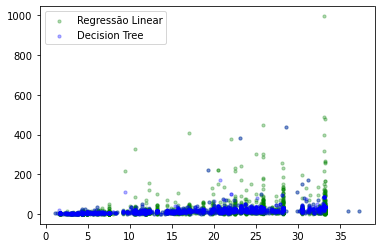

In [30]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(lista, y_test, s=10, c='g', alpha = 0.3, label='Regressão Linear')
ax1.scatter(lista,y_predT, s=10, c='y',alpha = 0.3, label='Decision Tree')
plt.legend(loc='upper left');
plt.show()

In [28]:
print('Erros da regressão Linear')
print('MAE: {} '.format(metrics.mean_absolute_error(y_test, predictions)))
metrics.mean_squared_error(y_test, predictions)
print('MSE: {} '.format(metrics.mean_squared_error(y_test, predictions)))
print('RMSE: {}'.format(np.sqrt(metrics.mean_squared_error(y_test, predictions))))

print('')
print('Erros da decision Tree')

print('MAE: {} '.format(metrics.mean_absolute_error(y_test,y_predT)))
metrics.mean_squared_error(y_test, predictions)
print('MSE: {} '.format(metrics.mean_squared_error(y_test,y_predT)))
print('RMSE: {}'.format(np.sqrt(metrics.mean_squared_error(y_test,y_predT))))


Erros da regressão Linear
MAE: 16.857395749119444 
MSE: 1801.0042843601375 
RMSE: 42.43824082546468

Erros da decision Tree
MAE: 14.432450550809 
MSE: 1488.996024776194 
RMSE: 38.587511253982086


## Conclusão:

Em relação a essa hipótese, é possível concluir que essa afirmação é verdadeira, pois nos gráficos de dispersão gerados durante nossa análise, a quantidade de reviews sempre foi maior na região do gráfico na qual se localizam os menores preços. Porém, não é possível ter certeza se isso ocorre por conta da maior procura por produtos mais baratos, ou por conta da qualidade do produto. 


Além de concluir a hipótese, foi possível também concluir que todos fatores e features incluídos na regressão linear realmente impactam no preço, pois a média de erro absoluta entre os valores da database, e dos valores obtidos por meio das regressões lineares foram relativamente baixas, pois o erro médio absoluto da regressão linear foi igual a 16.1% ,e do Linear Regression Tree foi igual a 14.1%.

Assim, também é possível concluir que no nosso caso, o Linear Regression Tree foi mais eficaz pois teve uma porcentagem menor de erro.
